# Lab 8: Define and Solve an ML Problem of Your Choosing

In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# suppress FutureWarning messages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# training time evaluation
import time

# winsorization
import scipy.stats as stats

# normalization
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# model choices
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# ensemble modeling
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor

# data partitioning
from sklearn.model_selection import train_test_split

# model selection and evaluation
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# model deployment
import pickle

### Load World Happiness Report 2018 Dataset

In [12]:
WHRDataSet_filename = os.path.join(os.getcwd(), "data", "WHR2018Chapter2OnlineData.csv")
df = pd.read_csv(WHRDataSet_filename)

### Rename Columns

In [13]:
cols_to_include = ['country', 'year', 'Life Ladder',
                   'Positive affect','Negative affect',
                   'Log GDP per capita', 'Social support',
                   'Healthy life expectancy at birth',
                   'Freedom to make life choices',
                   'Generosity', 'Perceptions of corruption',
                   'Confidence in national government', #
                   'Standard deviation of ladder by country-year',
                   'Standard deviation/Mean of ladder by country-year',
                   'GINI index (World Bank estimate)',
                   'GINI index (World Bank estimate), average 2000-15',
                   'gini of household income reported in Gallup, by wp5-year'
                  ]

renaming = {'Life Ladder': 'Happiness',
            'Log GDP per capita': 'LogGDP',
            'Social support': 'Support',
            'Healthy life expectancy at birth': 'Life',
            'Freedom to make life choices': 'Freedom',
            'Perceptions of corruption': 'Corruption',
            'Positive affect': 'Positive',
            'Negative affect': 'Negative',
            'Confidence in national government': 'Govt_Confidence', #
            'Standard deviation of ladder by country-year': 'Ladder_STD',
            'Standard deviation/Mean of ladder by country-year': 'Ladder_SD_Mean',
            'GINI index (World Bank estimate)': 'GINI_WB',
            'GINI index (World Bank estimate), average 2000-15': 'GINI_WB_Avg_00_15',
            'gini of household income reported in Gallup, by wp5-year': 'GINI_Gallup'
           }

df_renamed = df[cols_to_include].rename(renaming, axis=1)
df = df.drop(labels=cols_to_include, axis=1).join(df_renamed)

In [14]:
df.head(5)

,Democratic Quality,Delivery Quality,country,year,Happiness,Positive,Negative,LogGDP,Support,Life,Freedom,Generosity,Corruption,Govt_Confidence,Ladder_STD,Ladder_SD_Mean,GINI_WB,GINI_WB_Avg_00_15,GINI_Gallup
0,-1.929690,-1.655084,Afghanistan,2008,3.723590,0.517637,0.258195,7.168690,0.450662,49.209663,0.718114,0.181819,0.881686,0.612072,1.774662,0.476600,NaN,NaN,NaN
1,-2.044093,-1.635025,Afghanistan,2009,4.401778,0.583926,0.237092,7.333790,0.552308,49.624432,0.678896,0.203614,0.850035,0.611545,1.722688,0.391362,NaN,NaN,0.441906
2,-1.991810,-1.617176,Afghanistan,2010,4.758381,0.618265,0.275324,7.386629,0.539075,50.008961,0.600127,0.137630,0.706766,0.299357,1.878622,0.394803,NaN,NaN,0.327318
3,-1.919018,-1.616221,Afghanistan,2011,3.831719,0.611387,0.267175,7.415019,0.521104,50.367298,0.495901,0.175329,0.731109,0.307386,1.785360,0.465942,NaN,NaN,0.336764
4,-1.842996,-1.404078,Afghanistan,2012,3.782938,0.710385,0.267919,7.517126,0.520637,50.709263,0.530935,0.247159,0.775620,0.435440,1.798283,0.475367,NaN,NaN,0.344540


In [15]:
df.columns

Index(['Democratic Quality', 'Delivery Quality', 'country', 'year',
       'Happiness', 'Positive', 'Negative', 'LogGDP', 'Support', 'Life',
       'Freedom', 'Generosity', 'Corruption', 'Govt_Confidence', 'Ladder_STD',
       'Ladder_SD_Mean', 'GINI_WB', 'GINI_WB_Avg_00_15', 'GINI_Gallup'],
      dtype='object')

In [16]:
df.shape

(1562, 19)

In [17]:
df.dtypes

,0
Democratic Quality,float64
Delivery Quality,float64
country,object
year,int64
Happiness,float64
Positive,float64
Negative,float64
LogGDP,float64
Support,float64
Life,float64


## Data Preparation

### Handling String Values

Let's identify all columns with string values, as well as their unique values:

In [18]:
str_cols = df.select_dtypes(include=["object"]).columns

In [19]:
df[str_cols].head(1)

,country
0,Afghanistan


In [20]:
# print unique values of string columns
for i in str_cols:
    if df[i].nunique() < 100:
        print(i, df[i].nunique(), df[i].unique())
    else:
        print(i, df[i].nunique())

country 164


The country's name is neither predictive of its happiness nor sparse enough to one-hot encode (w/ `pd.get_dummies()`) into bianry columns so we will drop it.

<b>NOTE: </b> It is possible to group multiple rows with the same country into one row, but doing so will reduce the size of our data set significantly, affecting the model's ability to capture nuance in the data.

In [21]:
# drop inherently non-predictive columns
df.drop(labels='country', axis=1, inplace=True)

In [22]:
# check if string columns have changed
df.select_dtypes(include=["object"]).columns

Index([], dtype='object')

### Handling Outlier Numerical Values w/ Winsorization

The following code cell saves the names of feature columns with numerical values, which makes working with them easier down the line:

In [23]:
num_feat_cols = df.drop(labels='Happiness', axis=1).select_dtypes(include=['int64','float64']).columns
num_feat_cols

Index(['Democratic Quality', 'Delivery Quality', 'year', 'Positive',
       'Negative', 'LogGDP', 'Support', 'Life', 'Freedom', 'Generosity',
       'Corruption', 'Govt_Confidence', 'Ladder_STD', 'Ladder_SD_Mean',
       'GINI_WB', 'GINI_WB_Avg_00_15', 'GINI_Gallup'],
      dtype='object')

Let's apply winsorization to limit the influence of extreme values and mitigate potential issues:
<ul>
    <li>Extreme minimums and maximums can skew the mean and standard deviation, distorting statistical analysis.</li>
    <li>These extreme values can also lead to a model that does not generalize well to unseen data.</li>
</ul>

The `pd.DataFrame.describe()` method summarizes our data set. The measures of interest are the `mean`, standard deviation (`std`), `min`, and `max`.

Here are the aforementioned statistics before the operation:

In [24]:
# examine stats BEFORE winsorization
df[list(num_feat_cols) + ['Happiness']].describe().loc[['std','mean','min','max']]

,Democratic Quality,Delivery Quality,year,Positive,Negative,LogGDP,Support,Life,Freedom,Generosity,Corruption,Govt_Confidence,Ladder_STD,Ladder_SD_Mean,GINI_WB,GINI_WB_Avg_00_15,GINI_Gallup,Happiness
std,0.873259,0.981052,3.419787,0.107644,0.084006,1.184035,0.119370,7.960671,0.145408,0.164202,0.185538,0.190724,0.379684,0.119007,0.086609,0.083694,0.105410,1.121017
mean,-0.126617,0.004947,2011.820743,0.708969,0.263171,9.220822,0.810669,62.249887,0.728975,0.000079,0.753622,0.480207,2.003501,0.387271,0.372846,0.386948,0.445204,5.433676
min,-2.448228,-2.144974,2005.000000,0.362498,0.083426,6.377396,0.290184,37.766476,0.257534,-0.322952,0.035198,0.068769,0.863034,0.133908,0.241000,0.228833,0.223470,2.661718
max,1.540097,2.184725,2017.000000,0.943621,0.704590,11.770276,0.987343,76.536362,0.985178,0.677773,0.983276,0.993604,3.527820,1.022769,0.648000,0.626000,0.961435,8.018934


The following two code cells performs winsorization on all columns:

In [25]:
# winsorize label column
df['label_Happiness'] = stats.mstats.winsorize(df['Happiness'], limits=[0.01, 0.01])

In [26]:
# winsorize numberical feature columns
for i in num_feat_cols:
    temp = df[i]
    df[i] = stats.mstats.winsorize(df[i], limits=[0.01, 0.01])
    # if no changes occurred, then temp - df[i] == 0
    print(i, (temp - df[i]).fillna(0).unique().any())

Democratic Quality True
Delivery Quality True
year False
Positive True
Negative True
LogGDP True
Support True
Life True
Freedom True
Generosity True
Corruption True
Govt_Confidence True
Ladder_STD True
Ladder_SD_Mean True
GINI_WB True
GINI_WB_Avg_00_15 True
GINI_Gallup True


Examine the statistics. The `std`, `mean`, `min`, and `max` should have changed.

In [27]:
# examine stats AFTER winsorization
df[list(num_feat_cols) + ['Happiness','label_Happiness']].describe().loc[['std','mean','min','max']]

,Democratic Quality,Delivery Quality,year,Positive,Negative,LogGDP,Support,Life,Freedom,Generosity,Corruption,Govt_Confidence,Ladder_STD,Ladder_SD_Mean,GINI_WB,GINI_WB_Avg_00_15,GINI_Gallup,Happiness,label_Happiness
std,0.869275,0.977508,3.419787,0.106749,0.088067,1.182112,0.117182,7.945855,0.144024,0.163952,0.183191,0.190178,0.371878,0.115949,0.086330,0.083383,0.105105,1.121017,1.112060
mean,-0.124891,0.006860,2011.820743,0.709317,0.265728,9.221675,0.812850,62.344454,0.729475,0.000214,0.754302,0.480486,2.003268,0.386755,0.373045,0.387124,0.445374,5.433676,5.435275
min,-2.017452,-1.642179,2005.000000,0.465151,0.114123,6.633399,0.450662,42.407101,0.364206,-0.293943,0.161791,0.126142,1.283989,0.191132,0.257000,0.249091,0.269167,2.661718,3.174264
max,1.540097,2.184725,2017.000000,0.943621,0.599335,11.770276,0.982522,75.537704,0.985178,0.677773,0.983276,0.993604,3.043643,0.782641,0.648000,0.626000,0.961435,8.018934,7.614929


### Handling Missing (NaN) Numerical Values

By handling outliers first, we now have a non-skewed mean that we can safely impute into missing values.

Let's identify all columns with at least one row with a NaN value:

In [28]:
nan_count = np.sum(df.isnull())

nan_count

,0
Democratic Quality,171
Delivery Quality,171
year,0
Happiness,0
Positive,18
Negative,0
LogGDP,27
Support,0
Life,0
Freedom,29


In [29]:
nan_detected = nan_count > 0

nan_cols = nan_detected[nan_detected == True].index

print(nan_cols)

Index(['Democratic Quality', 'Delivery Quality', 'Positive', 'LogGDP',
       'Freedom', 'Generosity', 'Corruption', 'Govt_Confidence', 'GINI_WB',
       'GINI_WB_Avg_00_15', 'GINI_Gallup'],
      dtype='object')


In [30]:
df[nan_cols].head()

,Democratic Quality,Delivery Quality,Positive,LogGDP,Freedom,Generosity,Corruption,Govt_Confidence,GINI_WB,GINI_WB_Avg_00_15,GINI_Gallup
0,-1.929690,-1.642179,0.517637,7.168690,0.718114,0.181819,0.881686,0.612072,NaN,NaN,NaN
1,-2.017452,-1.635025,0.583926,7.333790,0.678896,0.203614,0.850035,0.611545,NaN,NaN,0.441906
2,-1.991810,-1.617176,0.618265,7.386629,0.600127,0.137630,0.706766,0.299357,NaN,NaN,0.327318
3,-1.919018,-1.616221,0.611387,7.415019,0.495901,0.175329,0.731109,0.307386,NaN,NaN,0.336764
4,-1.842996,-1.404078,0.710385,7.517126,0.530935,0.247159,0.775620,0.435440,NaN,NaN,0.344540


Since only numerical columns have NaN values, we will replace each of them with the mean:

In [31]:
for i in nan_cols:

    if df[i].dtype == 'object':
        continue

    # create dummy variables to indicate missingness
    df[f"{i}_na"] = df[i].isnull()

    # replace NaN with mean
    df[i].fillna(value=df[i].mean(), inplace=True)

In [32]:
np.sum(np.sum(df.isnull())) # check for nulls again

0

<h3>Handling Non-Normalized Numerical Values w/ Rescaling</h3>

We will use scikit-learn's `StandardScaler()` to rescale our numeric columns:

In [33]:
scaler = StandardScaler()

# rescale features
df_num_feat_scaled = pd.DataFrame(scaler.fit_transform(df[num_feat_cols]), columns=num_feat_cols)
df = df.drop(columns=num_feat_cols)
df = df.join(df_num_feat_scaled)

# rescale label
df_label_scaled = pd.DataFrame(scaler.fit_transform(df[['Happiness', 'label_Happiness']]), columns=['Happiness', 'label_Happiness'])
df = df.drop(columns=['Happiness', 'label_Happiness'])
df = df.join(df_label_scaled)

In [34]:
df[list(num_feat_cols) + ['Happiness', 'label_Happiness']].head()

,Democratic Quality,Delivery Quality,year,Positive,Negative,LogGDP,Support,Life,Freedom,Generosity,Corruption,Govt_Confidence,Ladder_STD,Ladder_SD_Mean,GINI_WB,GINI_WB_Avg_00_15,GINI_Gallup,Happiness,label_Happiness
0,-2.200922,-1.788314,-1.117604,-1.806633,-0.085560,-1.752488,-3.091806,-1.653566,-0.079649,1.137561,0.716547,0.730844,-0.614930,0.775111,1.053409e-15,7.070019e-16,-6.015655e-16,-1.525966,-1.539695
1,-2.307947,-1.780556,-0.825094,-1.181846,-0.325261,-1.611554,-2.224106,-1.601350,-0.354603,1.274083,0.538508,0.727918,-0.754737,0.039743,1.053409e-15,7.070019e-16,-3.758744e-02,-0.920796,-0.929651
2,-2.276677,-1.761200,-0.532585,-0.858183,0.108993,-1.566450,-2.337072,-1.552941,-0.906848,0.860763,-0.267394,-1.006013,-0.335287,0.069429,1.053409e-15,7.070019e-16,-1.279355e+00,-0.602588,-0.608880
3,-2.187909,-1.760164,-0.240075,-0.923011,0.016431,-1.542215,-2.490486,-1.507829,-1.637568,1.096907,-0.130465,-0.961423,-0.586154,0.683167,1.053409e-15,7.070019e-16,-1.176989e+00,-1.429479,-1.442430
4,-2.095200,-1.530103,0.052434,0.010068,0.024886,-1.455053,-2.494471,-1.464778,-1.391949,1.546844,0.119914,-0.250192,-0.551391,0.764476,1.053409e-15,7.070019e-16,-1.092729e+00,-1.473008,-1.486310


### Handling Boolean Values

Converting booleans into floats will make them suitable for modeling:

In [35]:
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(float)
df[bool_cols].head()

,Democratic Quality_na,Delivery Quality_na,Positive_na,LogGDP_na,Freedom_na,Generosity_na,Corruption_na,Govt_Confidence_na,GINI_WB_na,GINI_WB_Avg_00_15_na,GINI_Gallup_na
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


### Promoting Fair AI

To promote fair AI, our data must have an even distribution of labels.
- For classification tasks, this means obtaining a balanced number of labels and/or a balanced number of features with respect to the label.
- For regression tasks, this means obtaining an even distribution across the range of the label, avoiding clusters or gaps that could bias the model's predictions.

The standard deviation of happiness is close to 1, meaning we are close to a normal distribution, as shown in the graph below.

However, if we wanted to flatten this graph (in other words, ensure the frequency of each value is the same), we could use some transformation function. Unfortunately, there aren't any functions to transform this distribution, as far as I know.

Standard deviation for Happiness: 1.0003202562131746


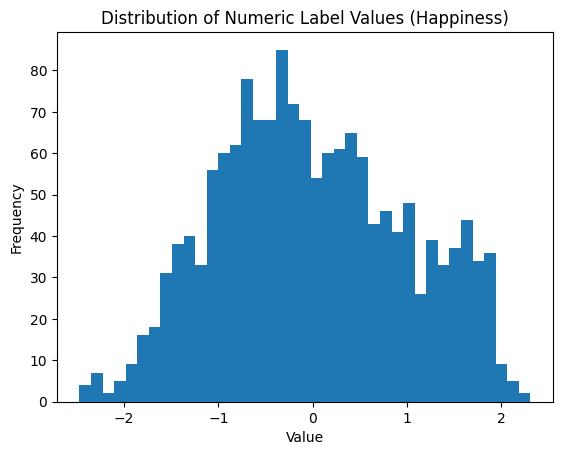

In [36]:
print("Standard deviation for Happiness:", df.describe()['Happiness']['std'])
plt.hist(df['Happiness'], bins=int(df['Happiness'].nunique()**0.5))
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Numeric Label Values (Happiness)')
plt.show()

## Data Exploration

### Finding High Correlations w/ Our Label

The `pd.DataFrame.corr()` method finds a column's correlation with other columns. Let's find all correlations with our Happiness label (after winsorization) and see which features have the strongest relationship:

Top Correlated Columns:
Index(['LogGDP', 'Ladder_SD_Mean', 'Life', 'Support', 'Delivery Quality',
       'Democratic Quality', 'Positive', 'Freedom'],
      dtype='object')


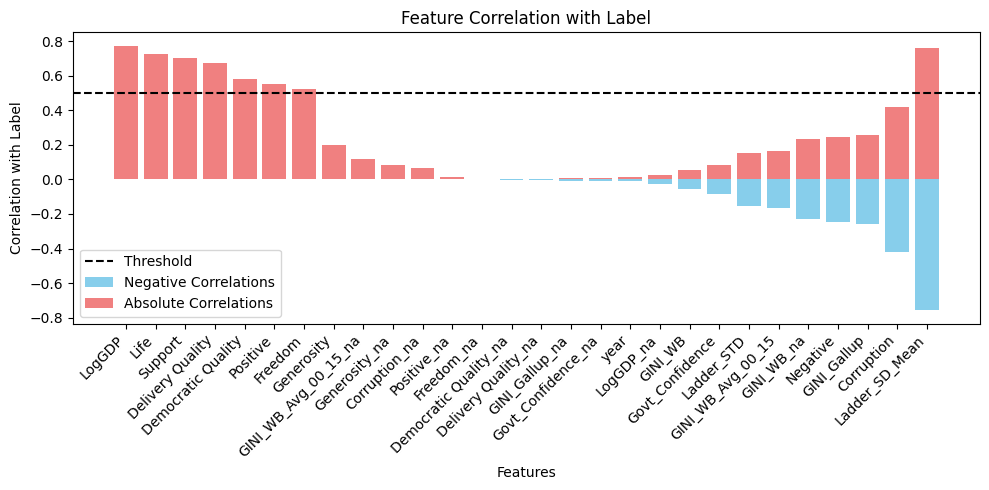

In [37]:
# find feature correlations with label
corr_matrix = round(df.corr(),5)
corrs = corr_matrix['label_Happiness']

# sort by highest correlation (excluding labels)
corrs_sorted = corrs.sort_values(ascending=False).drop(['Happiness','label_Happiness'])

# absolute value considers inversely proportional relationships
corrs_sorted_abs = np.absolute(corrs_sorted).sort_values(ascending=False)

# save the columns for feature selection
corrs_sorted_abs_cols = corrs_sorted_abs.index

# obtain top correlated columns
corr_threshold = 0.5
top_corr = corrs_sorted_abs[corrs_sorted_abs > corr_threshold].index

# print (optional)
print("Top Correlated Columns:")
print(top_corr)

# plot correlations
plt.figure(figsize=(10, 5))
plt.bar(corrs_sorted.index, corrs_sorted.values, color='skyblue', label='Negative Correlations') # negatives
plt.bar(corrs_sorted_abs.index, corrs_sorted_abs.values, color='lightcoral', label='Absolute Correlations') # absolute values
plt.axhline(y=corr_threshold, color='black', linestyle='--', label='Threshold') # threshold
plt.xlabel('Features')
plt.ylabel('Correlation with Label')
plt.title('Feature Correlation with Label')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

We will create a dataframe with just the columns in `top_corr`. Later, we will evaluate it's performance.

In [38]:
# build a df w/ the high correlated features columns
df_corrs = pd.DataFrame({})
for i in top_corr:
    df_corrs[i] = df[i]

df_corrs['label_Happiness'] = df['label_Happiness']

In [39]:
df_corrs.head()

,LogGDP,Ladder_SD_Mean,Life,Support,Delivery Quality,Democratic Quality,Positive,Freedom,label_Happiness
0,-1.752488,0.775111,-1.653566,-3.091806,-1.788314,-2.200922,-1.806633,-0.079649,-1.539695
1,-1.611554,0.039743,-1.601350,-2.224106,-1.780556,-2.307947,-1.181846,-0.354603,-0.929651
2,-1.566450,0.069429,-1.552941,-2.337072,-1.761200,-2.276677,-0.858183,-0.906848,-0.608880
3,-1.542215,0.683167,-1.507829,-2.490486,-1.760164,-2.187909,-0.923011,-1.637568,-1.442430
4,-1.455053,0.764476,-1.464778,-2.494471,-1.530103,-2.095200,0.010068,-1.391949,-1.486310


In [40]:
df_corrs.columns

Index(['LogGDP', 'Ladder_SD_Mean', 'Life', 'Support', 'Delivery Quality',
       'Democratic Quality', 'Positive', 'Freedom', 'label_Happiness'],
      dtype='object')

### Visualizing Correlations of Best Features

According to the plots below, each feature has a linear relationship with our label.

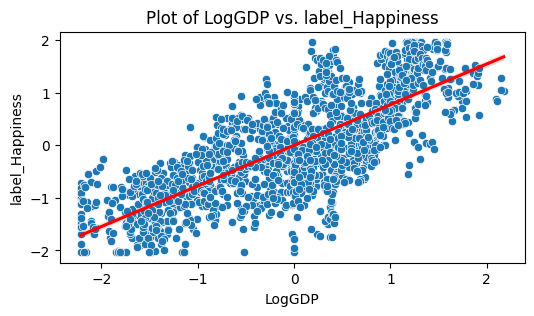

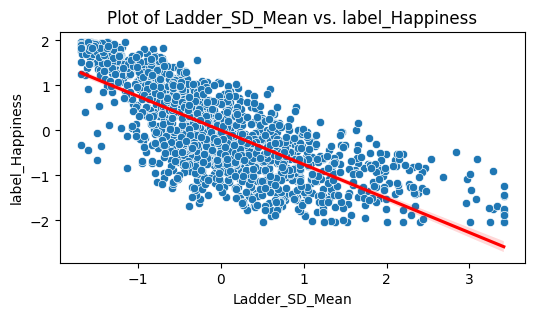

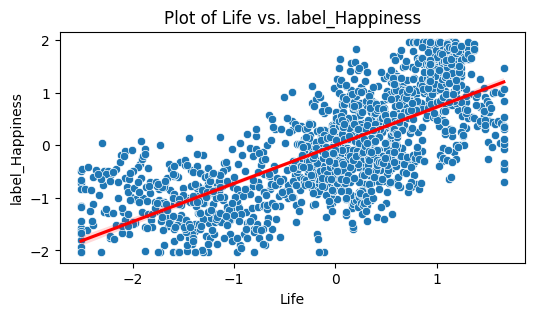

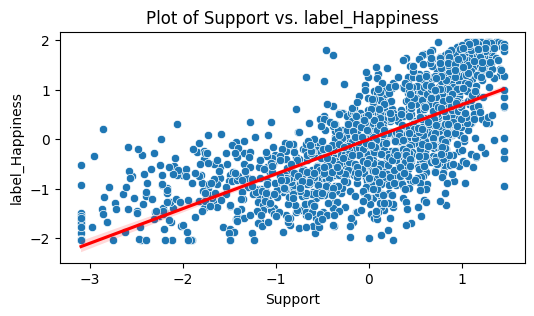

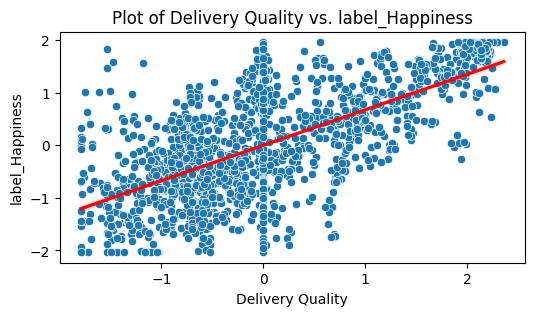

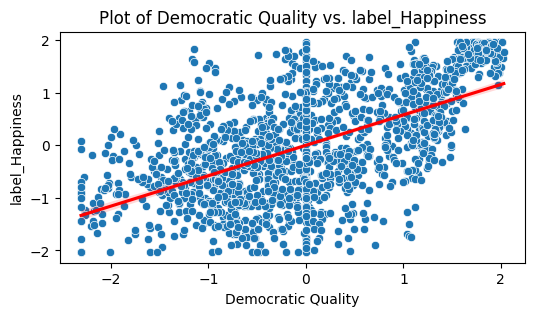

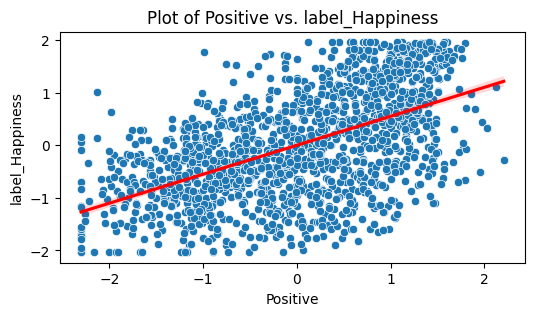

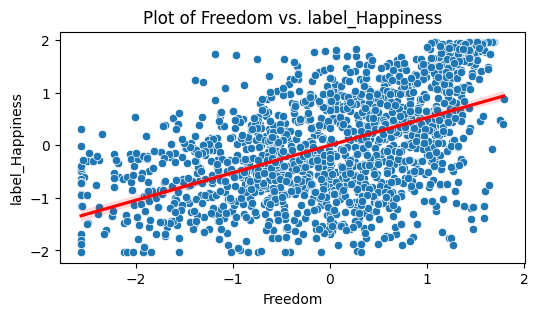

In [41]:
for i in df_corrs.columns:
    if i == 'label_Happiness':
        continue
    plt.figure(figsize=(6, 3))
    sns.scatterplot(x=i, y='label_Happiness', data=df_corrs)
    sns.regplot(x=i, y='label_Happiness', scatter=False, color='red', data=df_corrs)
    plt.title(f'Plot of {i} vs. label_Happiness')
    plt.xlabel(i)
    plt.ylabel('label_Happiness')
    plt.show()

### Pairplot

Another way to view these relationships is to create a pair plot, which shows that plotting our features against a label creates a 'tilt', or linearity with our label.

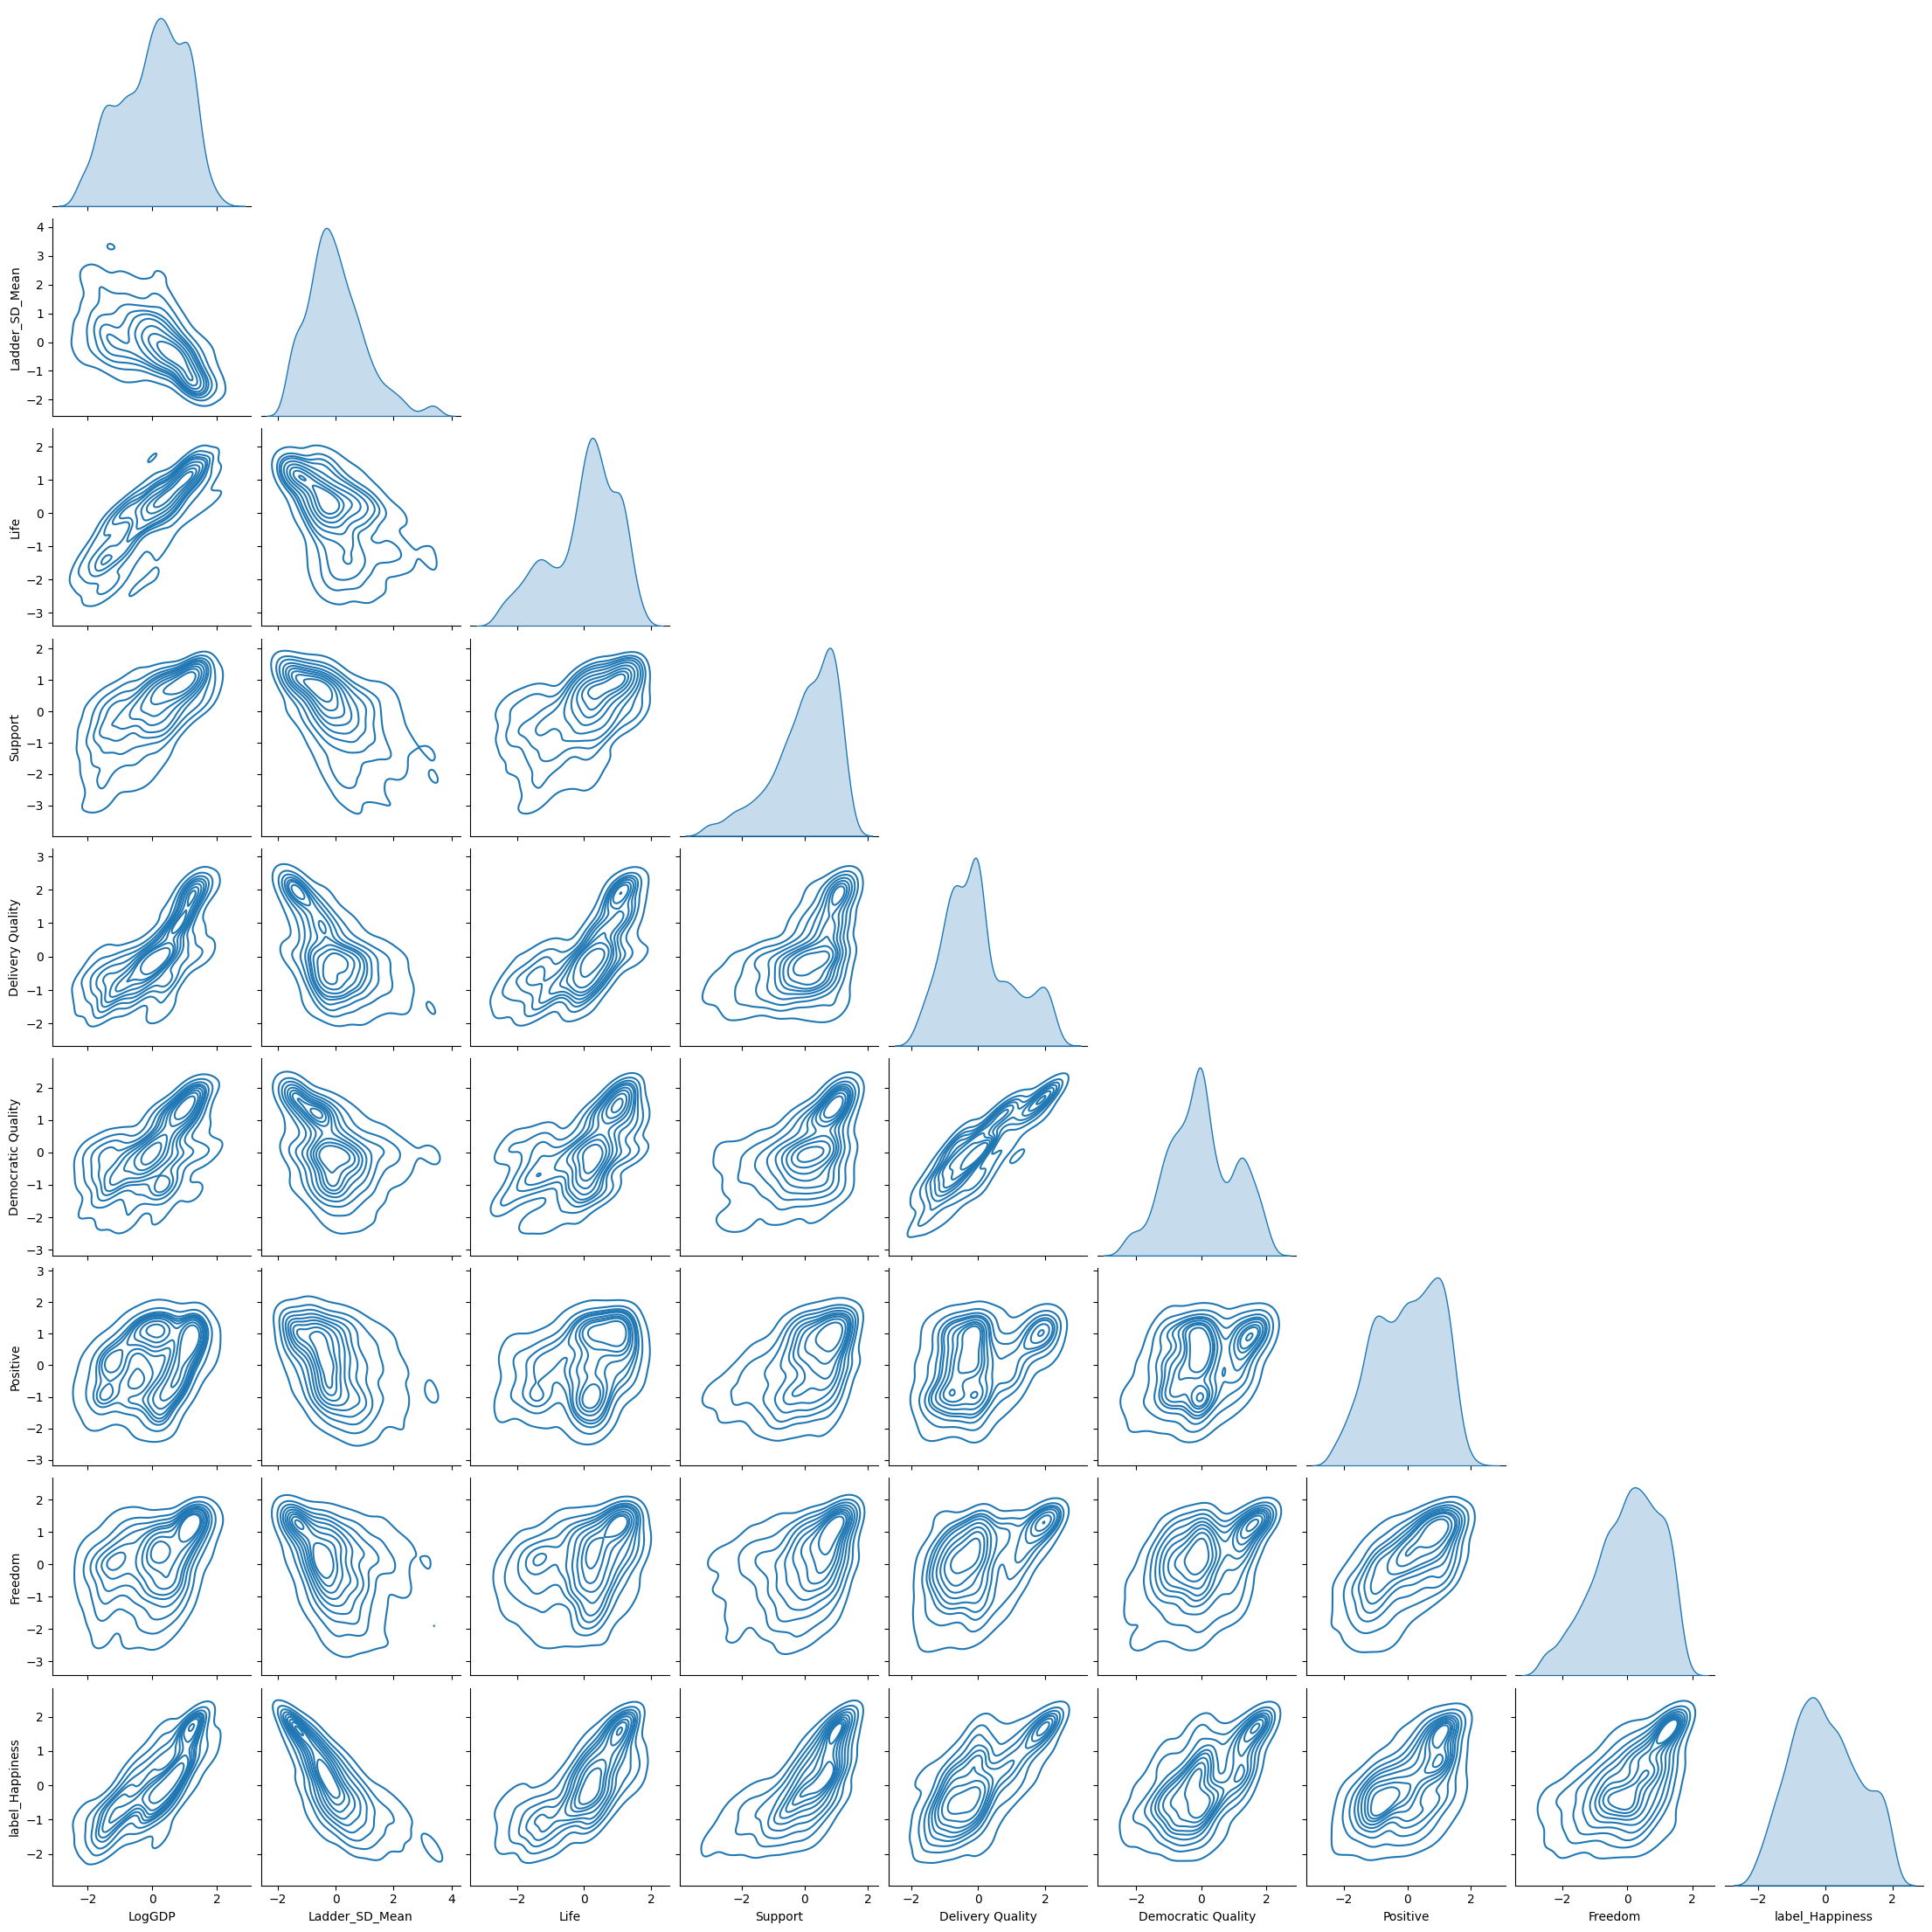

In [42]:
pairplot = sns.pairplot(df_corrs, kind='kde', corner=True)

In [43]:
pairplot.savefig("pairplot_output.png") # save pairplot

## Model Training

Our ML problem predicts a continuous real-numbered value. Earlier data analysis shows that there is linearity in our dataset. Therefore, scikit-learn's `LinearRegression` model will be appropriate to use.

I created my own functions for printing a linear regression's summary and performance:

In [44]:
def lr_summary(model, rounding=3, verbose=0):
    if verbose:
        print(f'Model Summary')
        for i in range(len(model.coef_)):
            print(f'w{i + 1} = {round(model.coef_[i], rounding)}')
        print(f'a = {round(model.intercept_, rounding)}')
        print()
    result = list(model.coef_)
    result.append(model.intercept_)
    return result

def lr_performance(y_test, prediction, t0, t1, verbose=0):
    rmse = np.sqrt(mean_squared_error(y_test, prediction))
    r2 = r2_score(y_test, prediction)
    t = t1 - t0
    if verbose:
        print('Model Performance')
        print('RMSE =   %.2f' % rmse)
        print(' R^2 =   %.2f' % r2)
        print('Time =   %.5f' % t)
        print()
    return (rmse, r2, t)

### Define Features and Label

In [45]:
y = df['label_Happiness']

In [46]:
X = df.drop(labels=['label_Happiness', 'Happiness'], axis=1)

### Split Data Into Training And Testing Sets

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [48]:
X_train.shape

(1249, 28)

### Train and Test Default Model (w/ ALL Features)

In [49]:
model_def = LinearRegression()

t0 = time.time()

model_def.fit(X_train, y_train)

t1 = time.time()

prediction_def = model_def.predict(X_test)

lr_performance(y_test, prediction_def, t0, t1, verbose=1)
lr_summary(model_def, rounding=4, verbose=1)
print("Default model done")

Model Performance
RMSE =   0.28
 R^2 =   0.93
Time =   0.02622

Model Summary
w1 = 0.0025
w2 = 0.0025
w3 = -0.1437
w4 = 0.026
w5 = -0.0452
w6 = 0.0523
w7 = 0.0003
w8 = -0.0358
w9 = -0.0137
w10 = -0.1022
w11 = 0.0189
w12 = 0.0218
w13 = 0.064
w14 = 0.0243
w15 = 0.0509
w16 = 0.0405
w17 = 0.1448
w18 = 0.0165
w19 = -0.046
w20 = 0.0189
w21 = 0.0573
w22 = -0.1225
w23 = -0.0394
w24 = 0.6517
w25 = -1.051
w26 = -0.0087
w27 = -0.0134
w28 = 0.0094
a = 0.0146

Default model done


### Train and Test w/ Top Correlated Features

In [50]:
X_top = df_corrs.drop(labels=['label_Happiness'], axis=1)

In [51]:
X_train_top, X_test_top, y_train, y_test = train_test_split(X_top, y, test_size=0.2)

In [52]:
X_train_top.columns

Index(['LogGDP', 'Ladder_SD_Mean', 'Life', 'Support', 'Delivery Quality',
       'Democratic Quality', 'Positive', 'Freedom'],
      dtype='object')

In [53]:
X_train_top.shape

(1249, 8)

In [54]:
model_top = LinearRegression()

t0 = time.time()

model_top.fit(X_train_top, y_train)

t1 = time.time()

prediction_top = model_top.predict(X_test_top)

lr_performance(y_test, prediction_top, t0, t1, verbose=1)
lr_summary(model_top, rounding=4, verbose=1)
print("Top model done")

Model Performance
RMSE =   0.46
 R^2 =   0.81
Time =   0.01211

Model Summary
w1 = 0.2823
w2 = -0.3444
w3 = 0.1516
w4 = 0.0921
w5 = 0.0137
w6 = 0.0272
w7 = 0.177
w8 = 0.0752
a = -0.0008

Top model done


Some things to note:
<li>The default model contains extreme weight magnitudes.</li>
<li><b>The feature dataset with the top correlated features isn't capturing patterns that the regular dataset can.</b></li>

## Model Selection

Let's improve our model's accuracy by implementing more rigorous evaluation techniques.

### Grid Search?

Unlike other training algorithms, like logistic regression (`C`) or kNN (`k`), linear regression doesn't have any hyperparameters. Therefore, it is not possible to create a hyperparameter grid and use scikit-learn's `GridSearchCV()` method to find the best model.

###  K-Fold Cross-Validation

Let's perform k-fold cross-validation to ensure our model isn't biased by a specific training set, which helps in reducing the model's variance (sensitivity to noisy data) and mitigating overfitting.

### Feature Selection

Let's perform feature selection to find the right balance between RMSE, R^2, and training time.

According to the scikit-learn documentation, `LinearRegression` does not have a `feature_importances_` attribute like other models such as `DecisionTreeClassifier`. Unfortunately, this means we can't directly pull the most important features. Thus, we have two approaches:
1. Iterate through the features in `corrs_sorted_abs_cols` by magnitude of correlation.
2. Iterate through the coefficients in the default `model`, which contains all features, by magnitude of weight.
   
We will use the first approach. From there, we can keep track of each model's performance and use NumPy's `min()`, `max()`, `argmin()`, and `argmax()` methods to find the best model.

The following code cell performs these steps in a for loop:
1. Perform feature selection by increasing the list of features used in our modeling dataset, starting with the highest correlation w/ our label.
2. Perform cross validation to fit and evaluate this iteration of the dataset.
3. Obtain RMSE (accuracy), R2, and time scores.
4. Append these scores to a list.
5. Repeat with the next highly correlated feature until all features have been included.

In [55]:
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

rmse_list_1 = []
r2_list_1 = []
t_list_1 = []
f_list = []

for i in range(len(corrs_sorted_abs_cols)):
    # Add new column
    f_list.append(corrs_sorted_abs_cols[i])

    # Create feature dataset with new column
    ith_X = df[f_list]

    # Begin CV
    ith_model = LinearRegression()

    ith_t0 = time.time()

    ### Cross-Validation (training + test)
        # Setting greater_is_better=False multiplies -1 to the mean to indicate
        # that the scorer is a loss function trying to minimize itself.
        # As such we have to cancel out the negative in the mean.
    ith_rmse = -1 * np.mean(cross_val_score(ith_model, ith_X, y, cv=5, scoring=rmse_scorer))
    ith_r2 = np.mean(cross_val_score(ith_model, ith_X, y, cv=5, scoring='r2'))

    # End CV
    ith_t1 = time.time()

    ith_t = ith_t1 - ith_t0

    # Append scores
    rmse_list_1.append(ith_rmse)
    r2_list_1.append(ith_r2)
    t_list_1.append(ith_t)

The following code cell finds the best scores and their indices:

In [56]:
# RMSE
best_rmse_idx = np.argmin(rmse_list_1)
best_rmse = np.min(rmse_list_1)

# R2
best_r2_idx = np.argmax(r2_list_1)
best_r2 = np.max(r2_list_1)

# Time
best_t_idx = np.argmin(t_list_1)
best_t = np.min(t_list_1)

# Save best columns for best model training
best_X_cols = corrs_sorted_abs_cols[0:best_rmse_idx + 1]
best_X = X[best_X_cols]

print(f'Best rmse found in model index {best_rmse_idx}, with {best_X_cols[best_rmse_idx]} added')

Best rmse found in model index 15, with GINI_WB_Avg_00_15_na added


### Visualize Model Selection and Performance

The following code cell graphs our model's performance as we include more features:

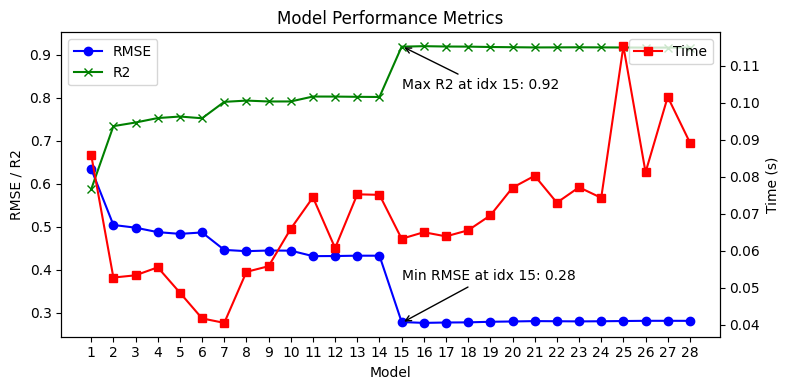

In [57]:
indices = range(1, len(rmse_list_1) + 1)

fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.set_xlabel('Model')
ax1.set_ylabel('RMSE / R2')
ax1.plot(indices, rmse_list_1, marker='o', label='RMSE', color='blue')
ax1.plot(indices, r2_list_1, marker='x', label='R2', color='green')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

ax1.set_xticks(indices)
# ax1.set_xticklabels(corrs_sorted_abs_cols[indices], rotation=45, ha='right')

ax1.annotate(f'Min RMSE at idx {best_rmse_idx}: {best_rmse:.2f}', xy=(best_rmse_idx, best_rmse),
             xytext=(best_rmse_idx, best_rmse + 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
ax1.annotate(f'Max R2 at idx {best_r2_idx}: {best_r2:.2f}', xy=(best_r2_idx, best_r2),
             xytext=(best_r2_idx, best_r2 - 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->',))


ax2 = ax1.twinx()
ax2.set_ylabel('Time (s)')
ax2.plot(indices, t_list_1, marker='s', label='Time', color='red')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

plt.title('Model Performance Metrics')

plt.tight_layout()
plt.show()

### Train The Best Model

Now that we have found our best model, we will train it separately.

In [58]:
X_train_best, X_test_best, y_train, y_test = train_test_split(best_X, y, test_size=0.2)

In [59]:
X_train_best.columns

Index(['LogGDP', 'Ladder_SD_Mean', 'Life', 'Support', 'Delivery Quality',
       'Democratic Quality', 'Positive', 'Freedom', 'Corruption',
       'GINI_Gallup', 'Negative', 'GINI_WB_na', 'Generosity',
       'GINI_WB_Avg_00_15', 'Ladder_STD', 'GINI_WB_Avg_00_15_na'],
      dtype='object')

In [60]:
X_train_best.shape

(1249, 16)

In [61]:
X_train_best.head(1)

,LogGDP,Ladder_SD_Mean,Life,Support,Delivery Quality,Democratic Quality,Positive,Freedom,Corruption,GINI_Gallup,Negative,GINI_WB_na,Generosity,GINI_WB_Avg_00_15,Ladder_STD,GINI_WB_Avg_00_15_na
634,1.294172,-1.613563,0.989811,1.448399,1.857824,1.743015,1.565229,1.154235,-1.503626,-6.015655e-16,-1.33996,0.0,1.963327,-0.784272,-1.322769,0.0


In [62]:
best_model = LinearRegression()

t0 = time.time()

best_model.fit(X_train_best, y_train)

t1 = time.time()

best_pred = best_model.predict(X_test_best)

rmse_lr, r2_lr, t_lr = lr_performance(y_test, best_pred, t0, t1, verbose=1)
lr_summary(best_model, rounding=4, verbose=1)
print("Best model done")

Model Performance
RMSE =   0.27
 R^2 =   0.92
Time =   0.01125

Model Summary
w1 = 0.1438
w2 = -1.0366
w3 = -0.0259
w4 = 0.0375
w5 = 0.0502
w6 = 0.0307
w7 = 0.0479
w8 = 0.0062
w9 = -0.1234
w10 = 0.0129
w11 = 0.0387
w12 = -0.003
w13 = 0.058
w14 = -0.0199
w15 = 0.6492
w16 = -0.1275
a = 0.0221

Best model done


<b>According to the RMSE scores, `best_model` performs twice as better as `model_top`! We now have an improved model.</b>

## Ensemble Modeling

We haven't considered other models we could incorporate through ensemble modeling.
For each model, we will
1. Perform grid search cross-validation to find the best hyperparameters
2. Train and test the best model with those hyperparameters
3. Compute the RMSE, R2, and training time
We will try the following models:
- Decision Trees
- K Nearest Neighbors
- Random Forest
- Gradient Boosting
- Stacking
  
At the end, we will visualize each model's scores to determine which stack could give the best balance between accuracy and time resources.

#### Decision Tree Regressor

In [63]:
dt_param_grid = {'max_depth': [4, 8, 16], 'min_samples_leaf': [25, 50, 75]}

dt_regressor = DecisionTreeRegressor()

dt_grid = GridSearchCV(dt_regressor, dt_param_grid, cv=5, scoring='neg_root_mean_squared_error')

dt_grid_search = dt_grid.fit(X_train_best, y_train)

rmse_dt = -1 * dt_grid_search.best_score_
dt_best_params = dt_grid_search.best_params_

print("Best DT model:")
print("RMSE: {:.2f}".format(rmse_dt))
print("Parameters:", dt_best_params)

Best DT model:
RMSE: 0.36
Parameters: {'max_depth': 8, 'min_samples_leaf': 25}


In [64]:
best_dt_model = DecisionTreeRegressor(max_depth=dt_best_params['max_depth'], min_samples_leaf=dt_best_params['min_samples_leaf'])

t0 = time.time()

best_dt_model.fit(X_train_best, y_train)

t1 = time.time()

t_dt = t1 - t0

best_dt_pred = best_dt_model.predict(X_test_best)
r2_dt = r2_score(y_test, best_dt_pred)

#### KNN Regressor

In [65]:
knn_param_grid = {'n_neighbors': [x*5 for x in range(1, 6)]}

knn_regressor = KNeighborsRegressor()

knn_grid = GridSearchCV(knn_regressor, knn_param_grid, cv=5, scoring='neg_root_mean_squared_error')

knn_grid_search = knn_grid.fit(X_train_best, y_train)

rmse_knn = -1 * knn_grid_search.best_score_
knn_best_params = knn_grid_search.best_params_

print("Best KNN model:")
print("RMSE: {:.2f}".format(rmse_knn))
print("Parameters:", knn_best_params)

Best KNN model:
RMSE: 0.31
Parameters: {'n_neighbors': 5}


In [66]:
best_knn_model = KNeighborsRegressor(n_neighbors=knn_best_params['n_neighbors'])

t0 = time.time()

best_knn_model.fit(X_train_best, y_train)

t1 = time.time()

t_knn = t1 - t0

best_knn_pred = best_knn_model.predict(X_test_best)
r2_knn = r2_score(y_test, best_knn_pred)

#### Random Forest

In [67]:
rf_param_grid = {'max_depth': [4, 8, 16, 32], 'n_estimators': [50, 100, 150, 200]}

rf_model = RandomForestRegressor()

rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='neg_root_mean_squared_error')

rf_grid_search = rf_grid.fit(X_train_best, y_train)

rmse_rf = -1 * rf_grid_search.best_score_
rf_best_params = rf_grid_search.best_params_

print("Best RF model:")
print("RMSE: {:.2f}".format(rmse_rf))
print("Parameters:", rf_best_params)

Best RF model:
RMSE: 0.19
Parameters: {'max_depth': 32, 'n_estimators': 150}


In [68]:
best_rf_model = RandomForestRegressor(max_depth=rf_best_params['max_depth'], n_estimators=rf_best_params['n_estimators'])

t0 = time.time()

best_rf_model.fit(X_train_best, y_train)

t1 = time.time()

t_rf = t1 - t0

best_rf_pred = best_rf_model.predict(X_test_best)
r2_rf = r2_score(y_test, best_rf_pred)

#### Gradient Boosting Regressor

In [69]:
gbdt_param_grid = {'max_depth': [2, 4, 8], 'n_estimators': [100, 200, 300]}

gbdt_model = GradientBoostingRegressor()

gbdt_grid = GridSearchCV(gbdt_model, gbdt_param_grid, cv=5, scoring='neg_root_mean_squared_error')

gbdt_grid_search = gbdt_grid.fit(X_train_best, y_train)

rmse_gbdt = -1 * gbdt_grid_search.best_score_
gbdt_best_params = gbdt_grid_search.best_params_

print("Best GBDT model:")
print("RMSE: {:.2f}".format(rmse_gbdt))
print("Parameters:", gbdt_best_params)

Best GBDT model:
RMSE: 0.13
Parameters: {'max_depth': 4, 'n_estimators': 300}


In [70]:
best_gbdt_model = GradientBoostingRegressor(max_depth=gbdt_best_params['max_depth'], n_estimators=gbdt_best_params['n_estimators'])

t0 = time.time()

best_gbdt_model.fit(X_train_best, y_train)

t1 = time.time()

t_gbdt = t1 - t0

best_gbdt_pred = best_gbdt_model.predict(X_test_best)
r2_gbdt = r2_score(y_test, best_gbdt_pred)

#### Stacking All Models

In [71]:
estimators = [
    ("LR", best_model),
    ("DT", best_dt_model),
    ("KNN", best_knn_model),
    ("RF", best_rf_model),
    ("GBDT", best_gbdt_model)
]

stacking_model = StackingRegressor(estimators=estimators, passthrough=False)

t0 = time.time()

stacking_model.fit(X_train_best, y_train)

t1 = time.time()

t_stack = t1 - t0

stacking_pred = stacking_model.predict(X_test_best)

rmse_stack = np.sqrt(mean_squared_error(y_test, stacking_pred))
r2_stack = r2_score(y_test, stacking_pred)

### Visualize Ensemble Modeling

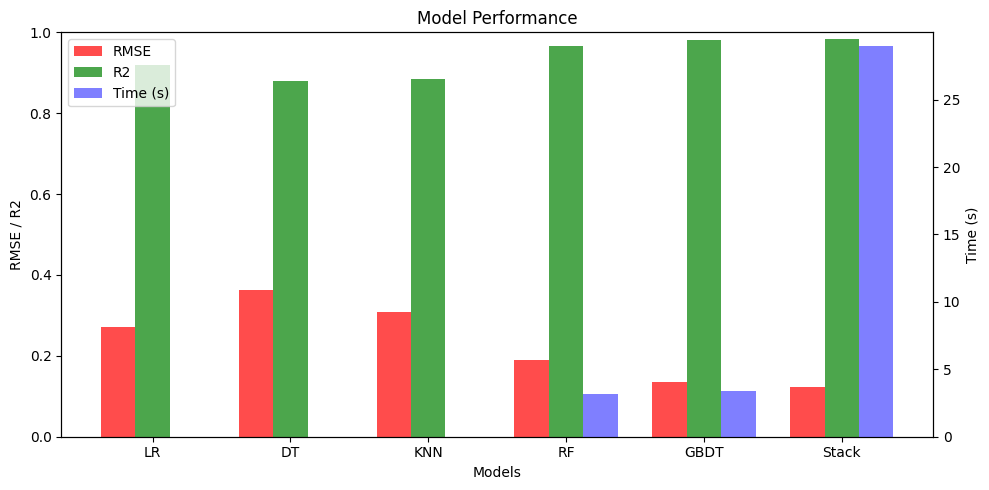

In [72]:
RMSE_Results = [rmse_lr, rmse_dt, rmse_knn, rmse_rf, rmse_gbdt, rmse_stack]
R2_Results = [r2_lr, r2_dt, r2_knn, r2_rf, r2_gbdt, r2_stack]
t_Results = [t_lr, t_dt, t_knn, t_rf, t_gbdt, t_stack]

rg = np.arange(len(RMSE_Results))

width = 0.25

fig, ax1 = plt.subplots(figsize=(10, 5))

# rmse and r2 results
bars1 = ax1.bar(rg - width, RMSE_Results, width=width, color='red', label='RMSE', alpha=0.7)

bars2 = ax1.bar(rg, R2_Results, width=width, color='green', label='R2', alpha=0.7)

# time results
ax2 = ax1.twinx()
bars3 = ax2.bar(rg + width, t_Results, width=width, color='blue', alpha=0.5, label='Time (s)')

# set x-axis labels
labels = ['LR', 'DT', 'KNN', 'RF', 'GBDT', 'Stack']
ax1.set_xticks(rg)
ax1.set_xticklabels(labels)

# set plot labels and title
ax1.set_xlabel("Models")
ax1.set_ylabel("RMSE / R2")
ax2.set_ylabel("Time (s)")
ax1.set_ylim(0, 1)  # Adjust based on your data range
ax2.set_ylim(0, max(t_Results) + 1)  # Adjust based on your data range
plt.title('Model Performance')

# legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

Stacking all models increased training time by a large factor. It is probably better to stack a handful of models, like LR, KNN, and one of the DT ensemble models (RF and GBDT), to produce the most accurate and efficient model.

In [73]:
best_estimators = [
    ("LR", best_model),
    ("KNN", best_knn_model),
    ("GBDT", best_gbdt_model)
]

best_stack_model = StackingRegressor(estimators=best_estimators, passthrough=False)

t0 = time.time()

best_stack_model.fit(X_train_best, y_train)

t1 = time.time()

t_stack = t1 - t0

best_stack_pred = best_stack_model.predict(X_test_best)

rmse_best_stack = np.sqrt(mean_squared_error(y_test, best_stack_pred))
r2_best_stack = r2_score(y_test, best_stack_pred)

print("RMSE:", rmse_best_stack, "R2:", r2_best_stack, "Time:", t1 - t0)

RMSE: 0.12627766022435116 R2: 0.98275142450223 Time: 16.200035572052002


## Deployment

In [74]:
# save model
pkl_model_filename = "Country_Happiness_Regression_Model.pkl"
pickle.dump(best_stack_model, open(pkl_model_filename, 'wb'))

In [75]:
# load model
persistent_model = pickle.load(open(pkl_model_filename, 'rb'))
persistent_model

StackingRegressor(estimators=[('LR', LinearRegression()),
                              ('KNN', KNeighborsRegressor()),
                              ('GBDT',
                               GradientBoostingRegressor(max_depth=4,
                                                         n_estimators=300))])

In [76]:
# see if models are the same
persistent_pred = persistent_model.predict(X_test_best)

if (best_stack_pred == persistent_pred).all():
    print("Best predictions equal persistent predictions. Persistent best model successful.")

Best predictions equal persistent predictions. Persistent best model successful.
